In [118]:
library(tensorflow)
library(keras3)
library(keras)
library(tfdatasets)
library(dplyr)
library(reticulate)
library(image.libfacedetection)

In [119]:
setwd("D:/Projects/Face recognition/faces/")

In [120]:
target_size <- c(300, 300)
batch_size <- 32

In [121]:
train_ds <- image_dataset_from_directory(
    "crop_train",
    seed = 11,
    label_mode = "binary",
    subset = "training",
    validation_split = 0.2,
    class_names = c("non-user", "user"),
    image_size = target_size,
    batch_size = batch_size
)

validation_ds <- image_dataset_from_directory(
    "crop_test",
    seed = 11,
    label_mode = "binary",
    subset = "validation",
    validation_split = 0.2,
    class_names = c("non-user", "user"),
    image_size = target_size,
    batch_size = batch_size
)

In [122]:
train_batch <- train_ds %>%
        as_iterator() %>%
        iter_next()

c(train_images, train_labels) %<-% train_batch

In [123]:
val_batch <- validation_ds %>%
        as_iterator() %>%
        iter_next()

c(val_images, val_labels) %<-% val_batch

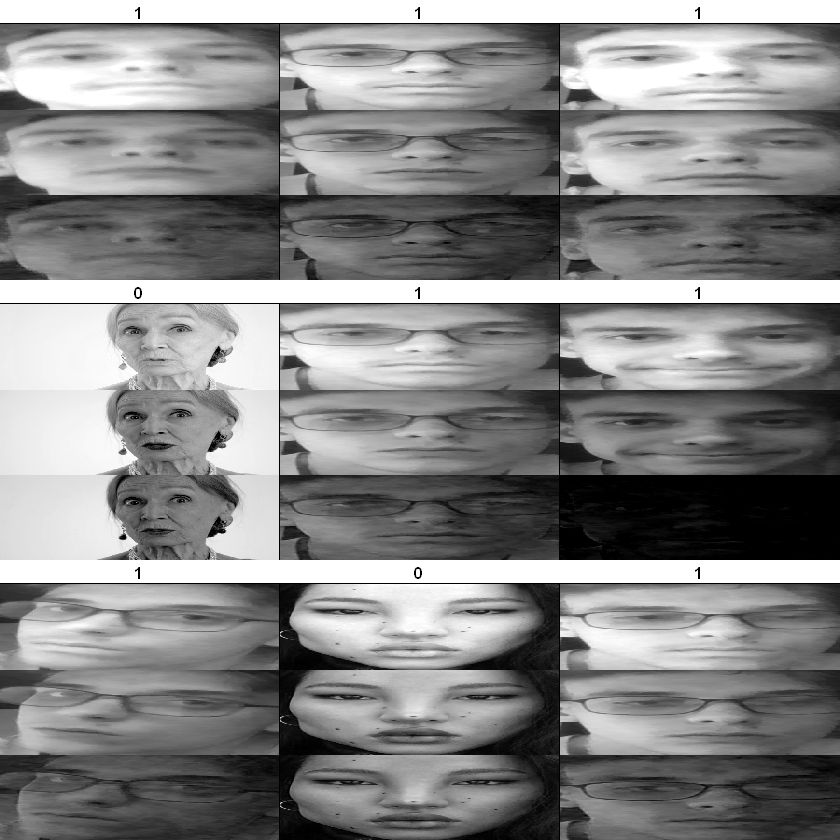

In [124]:
par(mfcol = c(3, 3))

par(mar = c(0, 0, 1.5, 0), xaxs = "i", yaxs = "i")

for (i in 1:9) {

    img <- image_to_array(
        train_images[i, , , ]
    )

    img <- t(apply(img, 2, rev))

    image(
        useRaster = TRUE,
        img,
        col = gray((0:255) / 255), xaxt = "n", yaxt = "n",
        main = paste(train_labels[i, ])
    )
}

In [125]:
layer_rescale <- function(dataset, images, labels) {
    dataset <- dataset %>% dataset_map(
        function(images, labels) {
            list(layer_rescaling(images, scale = 1/127.5, offset = -1),
            labels)
        }
    )
    return(dataset)
}


In [126]:
train_ds <- layer_rescale(train_ds, train_images, train_labels)
validation_ds <- layer_rescale(validation_ds, val_images, val_labels)

In [127]:
pre_trained_model <- application_xception(
    input_shape = c(target_size, 3),
    include_top = FALSE,
    weights = "imagenet"
)

freeze_weights(pre_trained_model)

In [128]:
input <- pre_trained_model$input

output <-
    pre_trained_model$output %>%
    layer_global_average_pooling_2d() %>%
    #layer_dense(512, activation = "relu") %>%
    #layer_dropout(0.2) %>%
    layer_dense(1, activation = "sigmoid")

model_build <- keras_model(input, output)

In [129]:
model_build %>%
    compile(
        loss = "binary_crossentropy",
        optimizer = optimizer_adam(),
        metrics = "accuracy"
    )

In [130]:
summary(model_build)

Model: "functional_3"
┌────────────────────┬──────────────────┬────────────┬─────────────────┬───────
│ Layer (type)       │ Output Shape     │    Param # │ Connected to    │ Trai… 
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────
│ input_layer_1      │ (None, 300, 300, │          0 │ -               │   -   
│ (InputLayer)       │ 3)               │            │                 │       
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────
│ block1_conv1       │ (None, 149, 149, │        864 │ input_layer_1[… │   N   
│ (Conv2D)           │ 32)              │            │                 │       
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────
│ block1_conv1_bn    │ (None, 149, 149, │        128 │ block1_conv1[0… │   N   
│ (BatchNormalizati… │ 32)              │            │                 │       
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────
│ block1_conv1_act

In [131]:
early_stopping <- callback_early_stopping(
    monitor = "val_loss",
    min_delta = 1e-4,
    patience = 5,
    verbose = 1
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 2,
    verbose = 1
)

callbacks_file <- callback_model_checkpoint(
    "callbacks/best_{epoch}.keras",
    save_best_only = TRUE,
    monitor = "val_loss",
    mode = "min"
)


callbacks <- list(early_stopping, reduce_lr, callbacks_file)

In [132]:
history <- model_build %>% fit(
    train_ds,
    epochs = 10,
    validation_data = validation_ds,
    callbacks = callbacks
)

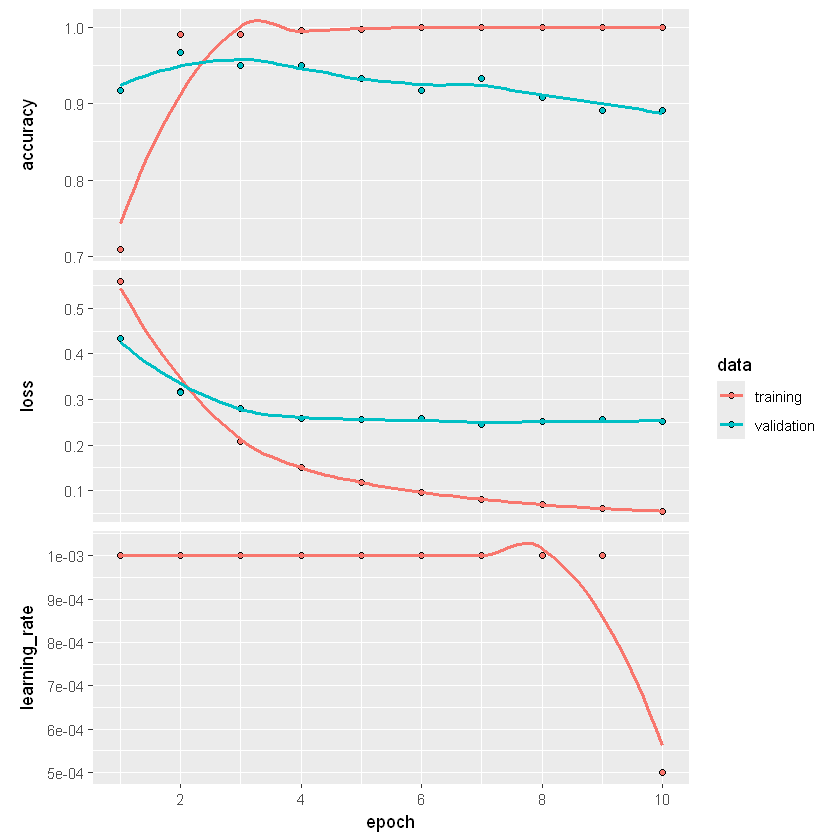

In [133]:
plot(history, type = "b")

In [134]:
model_build <- load_model("callbacks/best_7.keras")

0.9075522


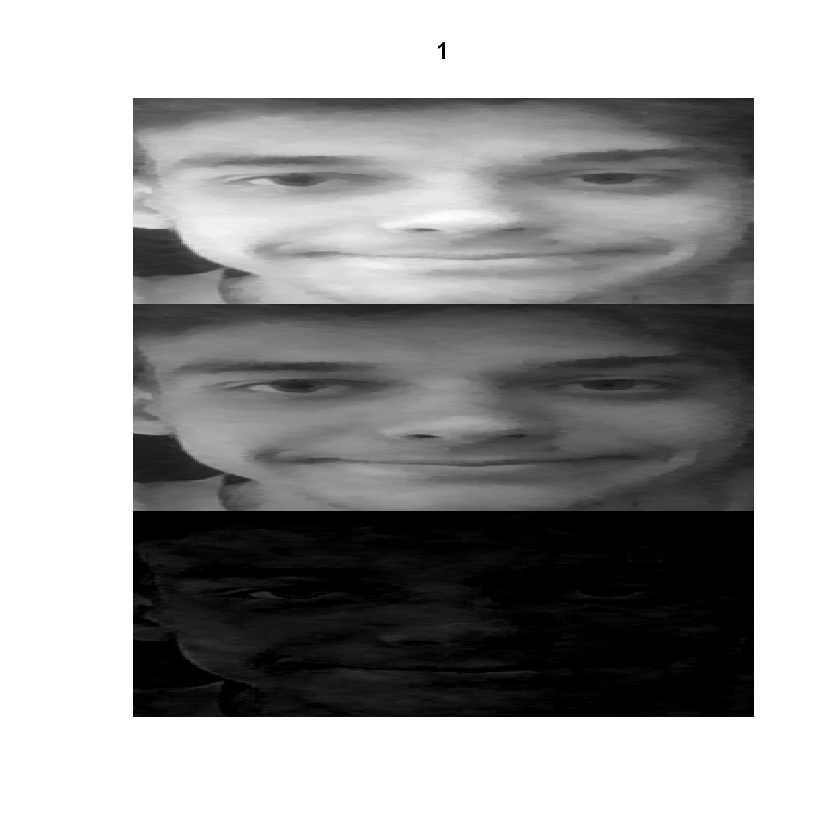

In [137]:
img_tensor <-
  "crop_train/user/user_10.png" %>%
  tf$io$read_file() %>%
  tf$io$decode_image(channels = 3) %>%
  tf$image$resize(as.integer(target_size))

img_tensor_rev <- t(apply(img_tensor, 2, rev))

image(
  img_tensor_rev,
  axes = FALSE,
  asp = 1,
  col = gray((0:255) / 255), xaxt = "n", yaxt = "n",
  main = paste(train_labels[i, ])
)

img_tensor <- img_tensor %>% tf$expand_dims(axis = 0L)

img_tensor <- (img_tensor / 127.5) - 1

score <- model_build %>% predict(img_tensor)

score